# Overview
This notebook will examine quantitative 7T MRI measures projected onto hippocampal midthickness surfaces and averaged across 10 subjects. At the end, we will combine this with Histology data and examine conserved features

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import nibabel as nib
import scipy
import sys
sys.path.insert(1, '/export03/data/opt/hippunfold_toolbox/hippunfold_toolbox')
import plotting
import utils
import copy
import glob
sys.path.insert(1, '/export03/data/opt/Hippo_Spin_Testing')
from hippo_spin_testing import spin_test


In [27]:
micapipe_dir = '../sourcedata/Supersession_PNI'
hippunfold_dir = '../hippunfold/PNI_v1.3.0_super/hippunfold'

subs = ['PNC002', 'PNC003', 'PNC006', 'PNC007', 'PNC009', 'PNC010', 'PNC015', 'PNC016', 'PNC018', 'PNC019']
ses = ''
hemis = ['L','R']
labels = ['hipp','dentate'] 

# here we will generate multiple depth-wise surfaces
layers = np.linspace(-0.25,1.25,num=25)
gm = np.where(np.logical_and(layers>=0,  layers <=1))[0]
ind = [range(7262), range(7262,7262+1788)]
features = ['qT1','MTR','T2star','FA','ADC']


In [3]:
for s,sub in enumerate(subs):
    cmd = f'mkdir -p {hippunfold_dir}/sub-{sub}/surf/depths'
    !{cmd}
    for h,hemi in enumerate(hemis):
        for l,layer in enumerate(layers):
            if not glob.glob(f'{hippunfold_dir}/sub-{sub}/surf/depths/sub-{sub}_hemi-{hemi}_layer-{layer}.surf.gii'):
                cmd1 = f'wb_command -surface-cortex-layer '\
                    f'{hippunfold_dir}/sub-{sub}/surf/sub-{sub}_hemi-{hemi}_space-T1w_den-0p5mm_label-hipp_inner.surf.gii '\
                    f'{hippunfold_dir}/sub-{sub}/surf/sub-{sub}_hemi-{hemi}_space-T1w_den-0p5mm_label-hipp_outer.surf.gii '\
                    f'{layer} '\
                    f'{hippunfold_dir}/sub-{sub}/surf/depths/sub-{sub}_hemi-{hemi}_layer-{layer}.surf.gii'
                !{cmd1}
            for f,feature in enumerate(features):
                if not glob.glob(f'{hippunfold_dir}/sub-{sub}/surf/depths/sub-{sub}_hemi-{hemi}_layer-{layer}_{feature}.shape.gii'):
                    cmd2 = f'wb_command -volume-to-surface-mapping '\
                        f'{micapipe_dir}/sub-{sub}/anat/sub-{sub}_space-nativepro_{feature}.nii.gz '\
                        f'{hippunfold_dir}/sub-{sub}/surf/depths/sub-{sub}_hemi-{hemi}_layer-{layer}.surf.gii '\
                        f'{hippunfold_dir}/sub-{sub}/surf/depths/sub-{sub}_hemi-{hemi}_layer-{layer}_{feature}.shape.gii '\
                        f'-trilinear'
                    !{cmd2}

In [8]:
hipp_dat_7T = np.zeros([7262,2,len(subs),len(layers),len(features)])*np.nan

for f,feature in enumerate(features):
    for s,sub in enumerate(subs):
        for h,hemi in enumerate(hemis):
            for l,layer in enumerate(layers):
                try:
                    d = nib.load(f'{hippunfold_dir}/sub-{sub}/surf/depths/sub-{sub}_hemi-{hemi}_layer-{layer}_{feature}.shape.gii')
                    hipp_dat_7T[:,h,s,l,f] = d.darrays[0].data
                except:
                    print(f'sub-{sub}_{hemi}_{feature} not found')

In [25]:
hipp_dat_7T.shape

(7262, 2, 10, 25, 5)

In [9]:
# profile align
V=[]
F=[]
for f,feature in enumerate(features):
    for s,sub in enumerate(subs):
        for h,hemi in enumerate(hemis):
            sd = hipp_dat[:,h,s,:,f]
            # profile alignment
            sd = utils.profile_align(sd,V,F)    
            hipp_dat_7T[:,h,s,:,f] = sd

/export03/data/opt/venv/lib/python3.8/site-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/export03/data/opt/venv/lib/python3.8/site-packages/numpy/lib/function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


/export03/data/opt/venv/lib/python3.8/site-packages/brainspace/plotting/base.py:287: UserWarning: Interactive mode requires 'panel'. Setting 'interactive=False'
  warnings.warn("Interactive mode requires 'panel'. "


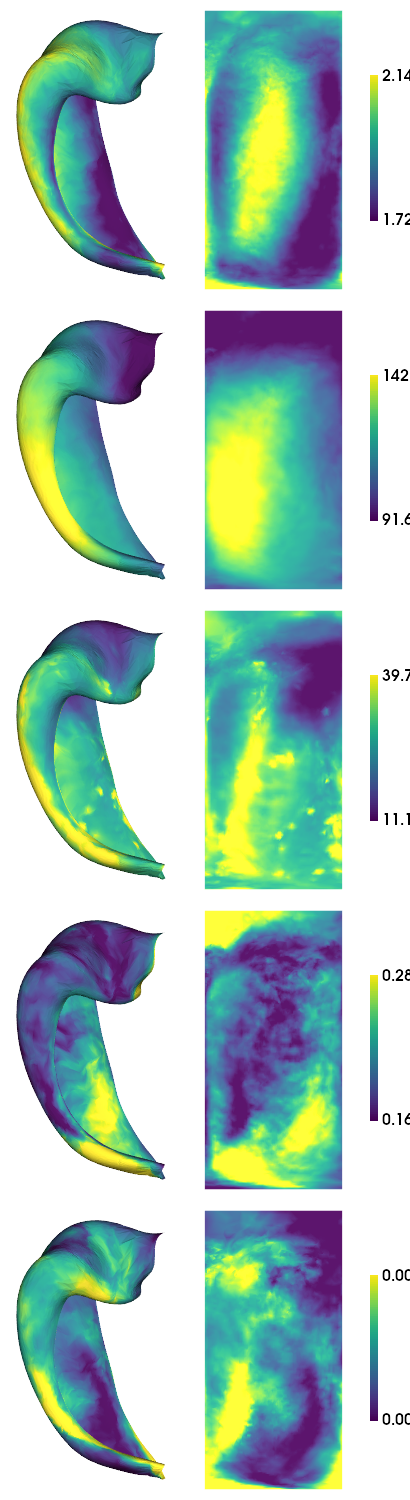

In [28]:
cdata = np.nanmean(hipp_dat_7T,axis=(1,2)) # average over subjects and hemispheres
plotting.surfplot_canonical_foldunfold(np.nanmean(cdata[:,gm,:],axis=1), color_bar=('right'), hemis=['L'], labels=['hipp'], unfoldAPrescale=True, share='row', tighten_cwindow=True, embed_nb=True)

In [29]:
!mkdir ../snapshots/img_struct
for f,feature in enumerate(features):
    plotting.surfplot_canonical_foldunfold(np.nanmean(cdata[:,gm,f],axis=1), labels=['hipp'], color_bar=('right'), hemis=['L'], unfoldAPrescale=True, 
        share='row', tighten_cwindow=True, embed_nb=True, screenshot=True, filename=f'../snapshots/img_struct/{feature}.png')

mkdir: cannot create directory ‘../snapshots/img_struct’: File exists


In [37]:
# add in 9.4T data
tmp = np.load("../checkpoints/struct-HISTO-proc.npy")[:,:,-4*3:]
hipp_dat_9p4T = np.zeros((7262,tmp.shape[1],tmp.shape[2]))
# resample
for g in range(25):
    for m in range(12):
        hipp_dat_9p4T[:,g,m],_,_ = utils.density_interp('unfoldiso','0p5mm',tmp[:,g,m],'hipp')
hipp_dat_9p4T = hipp_dat_9p4T.reshape((7262,25,3,2,2)) # v, depth, feature, sub, hemi
hipp_dat_9p4T = hipp_dat_9p4T.transpose(0,4,3,1,2)
hipp_dat_9p4T.shape

ValueError: cannot reshape array of size 19202400 into shape (7262,25,3,2,2)

In [116]:
features_9p4T = ['PD', 'R1', 'R2star']

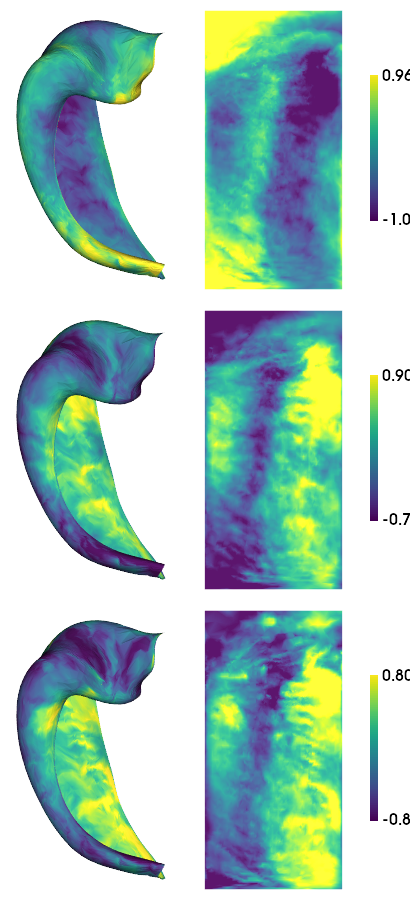

In [43]:
cdata = np.nanmean(hipp_dat_9p4T,axis=(1,2)) # average over subjects and hemispheres
plotting.surfplot_canonical_foldunfold(np.nanmean(cdata[:,gm,:],axis=1), color_bar=('right'), hemis=['L'], labels=['hipp'], unfoldAPrescale=True, share='row', tighten_cwindow=True, embed_nb=True)

In [44]:
!mkdir ../snapshots/img_struct
for f,feature in enumerate(features_9p4T):
    plotting.surfplot_canonical_foldunfold(np.nanmean(cdata[:,gm,f],axis=1), labels=['hipp'], color_bar=('right'), hemis=['L'], unfoldAPrescale=True, 
        share='row', tighten_cwindow=True, embed_nb=True, screenshot=True, filename=f'../snapshots/img_struct/{feature}.png')

mkdir: cannot create directory ‘../snapshots/img_struct’: File exists


## stability between subjects

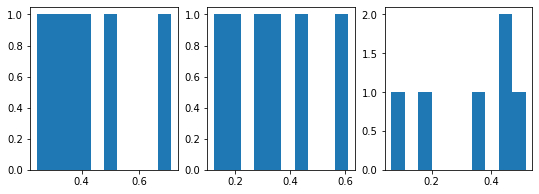

In [129]:
mfcorr = []
sdfcorr = []
corr = np.zeros((2*2,2*2,len(features_9p4T)))
fig, ax = plt.subplots(nrows=1, ncols=len(features_9p4T), figsize=(3*len(features_9p4T),3))
for f,feature in enumerate(features_9p4T):
    cdat = np.nanmean(hipp_dat_9p4T[:,:,:,gm,f],axis=3).reshape((7262,-1))
    corr[:,:,f] = np.corrcoef(cdat.T)
    fcorr = corr[:,:,f][np.triu_indices(4,k=1)]
    ax[f].hist(fcorr)
    mfcorr.append(np.mean(fcorr))
    sdfcorr.append(np.std(fcorr))

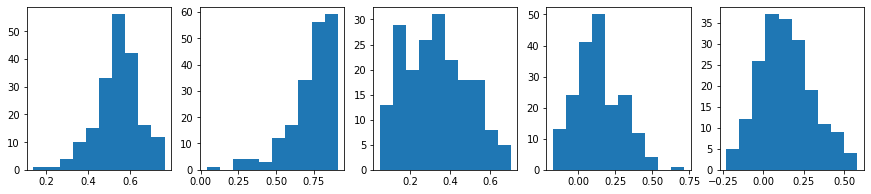

In [130]:
corr = np.zeros((2*10,2*10,len(features)))
fig, ax = plt.subplots(nrows=1, ncols=len(features), figsize=(3*len(features),3))
for f,feature in enumerate(features):
    cdat = np.nanmean(hipp_dat_7T[:,:,:,gm,f],axis=3).reshape((7262,-1))
    corr[:,:,f] = np.corrcoef(cdat.T)
    fcorr = corr[:,:,f][np.triu_indices(20,k=1)]
    ax[f].hist(fcorr)
    mfcorr.append(np.mean(fcorr))
    sdfcorr.append(np.std(fcorr))

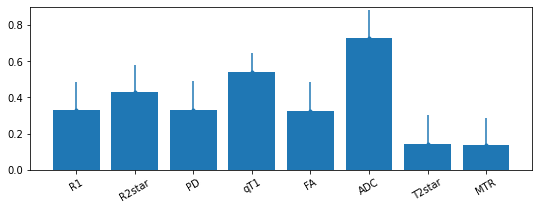

In [132]:
labels = features_9p4T + features
myorder=[1,2,0,3,6,7,5,4]
labels = [labels[i] for i in myorder]
mfcorr = [mfcorr[i] for i in myorder]
sdfcorr = [sdfcorr[i] for i in myorder]

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(3*len(features_9p4T),3))
plt.bar(range(8),mfcorr)
plt.errorbar(range(8),mfcorr, yerr=sdfcorr, fmt=".")
plt.xticks(ticks=range(8),labels=labels,rotation=30)
plt.ylim([0,.9]);

## gradients

In [67]:
sys.path.insert(1, '/data/mica1/01_programs/micapipe-v0.2.0/functions')
from build_mpc import build_mpc
from brainspace.gradient import GradientMaps

In [73]:
modality_data = np.concatenate((np.nanmean(hipp_dat_9p4T,axis=(1,2)),np.nanmean(hipp_dat_7T,axis=(1,2))),axis=2)
modality_data.shape

(7262, 25, 8)

In [75]:
MP = np.reshape(modality_data[:,gm,:],(7262,-1)).T
MPC, I, problemNodes = build_mpc(np.concatenate((MP,np.mean(MP,axis=0).reshape((1,-1)))))

/data/mica1/01_programs/micapipe-v0.2.0/functions/build_mpc.py:116: RuntimeWarning: divide by zero encountered in true_divide
  MPC = 0.5 * np.log( np.divide(1 + R, 1 - R) )


(-0.5, 7261.5, 7261.5, -0.5)

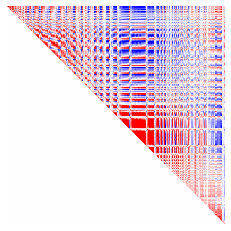

In [76]:
plt.imshow(MPC, vmin=-1, vmax=1, cmap='bwr')
plt.axis('off')

In [77]:
# gradient decomposition
mmgm = GradientMaps(n_components=5)
mmgm.fit(MPC)

/export03/data/opt/venv/lib/python3.8/site-packages/brainspace/gradient/embedding.py:70: UserWarning: Affinity is not symmetric. Making symmetric.
  warnings.warn('Affinity is not symmetric. Making symmetric.')


GradientMaps(n_components=5)

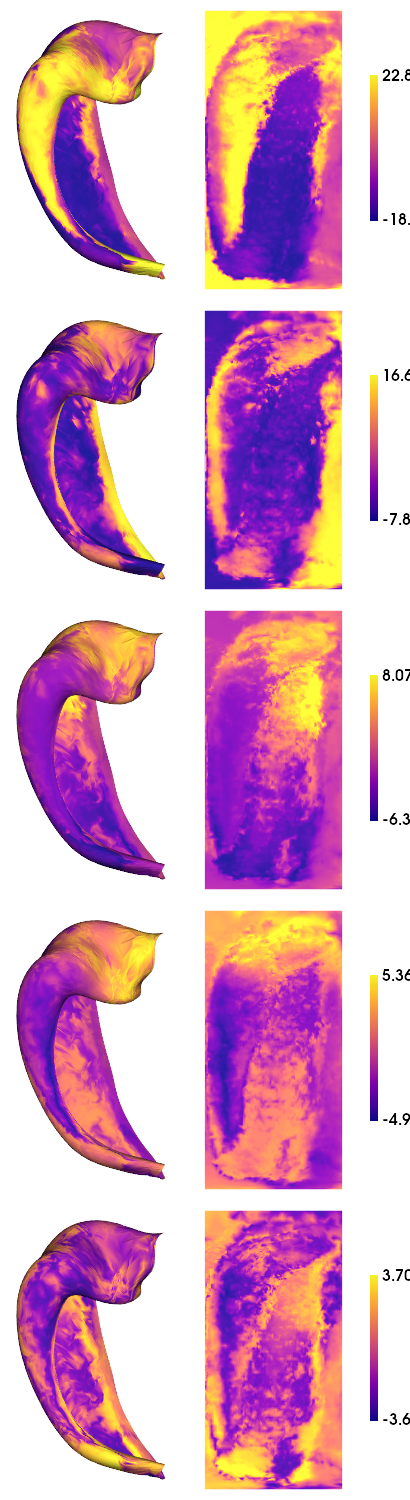

In [79]:
plotting.surfplot_canonical_foldunfold(mmgm.gradients_, labels=['hipp'], hemis=['L'], unfoldAPrescale=True, den='0p5mm', cmap='plasma', color_bar='right', share='row',  tighten_cwindow=False, embed_nb=True)

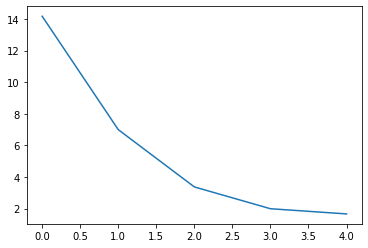

In [80]:
plt.plot(mmgm.lambdas_)

## save

In [14]:
# save 2D map
for f,feature in enumerate(features):
    cdat = np.nanmean(cdata[:,gm,f],axis=1).flatten()
    data_array = nib.gifti.GiftiDataArray(data=cdat)
    image = nib.gifti.GiftiImage()
    image.add_gifti_data_array(data_array)
    nib.save(image, f'../maps/MRI-7T-{feature}_average-20_hemi-mix_den-0p5mm_label-hipp.shape.gii')